### Imports


In [1]:
import transformers, datasets, sentencepiece
import numpy as np
from datasets import load_dataset
transformers.__version__, datasets.__version__, sentencepiece.__version__

('4.39.3', '2.18.0', '0.2.0')

### Dataset

In [2]:
from datasets import load_dataset
# possible language pairs: https://opus.nlpl.eu/KDE4.php
data = load_dataset("kde4", lang1="en", lang2="fr")
data

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for kde4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/kde4
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/210173 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [3]:
small = data["train"].shuffle(seed=42).select(range(5000))
data = small
data

Dataset({
    features: ['id', 'translation'],
    num_rows: 5000
})

In [4]:
split = data.train_test_split(seed=42)

In [5]:
split

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 3750
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 1250
    })
})

In [6]:
split['train'][0]

{'id': '160402',
 'translation': {'en': 'Swap Usage: %1% of %2 MiB',
  'fr': "Utilisation de la mémoire d'échange & #160;: %1 & #160;% sur %2 & #160; Mionot available means the system does not have swap"}}

### Tokenizer

In [7]:
from transformers import AutoTokenizer

checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [8]:
en = split['train'][5]['translation']['en']
fr = split['train'][5]['translation']['fr']
en, fr

('Box Drawing', 'FiletsKCharselect unicode block name')

In [9]:
inputs = tokenizer(en)
inputs

{'input_ids': [10384, 31730, 0], 'attention_mask': [1, 1, 1]}

In [10]:
targets = tokenizer(text_target=fr)
targets

{'input_ids': [15154, 4378, 751, 22295, 1689, 5939, 12942, 10784, 383, 10661, 81, 6587, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [11]:
tokenizer.convert_ids_to_tokens(targets['input_ids'])
# unlike bert __ in the starting and for split token no __ 
# a special token </s> denoting end of the sentence 

['▁Fil',
 'ets',
 'K',
 'Char',
 'se',
 'lect',
 '▁uni',
 'code',
 '▁b',
 'lock',
 '▁n',
 'ame',
 '</s>']

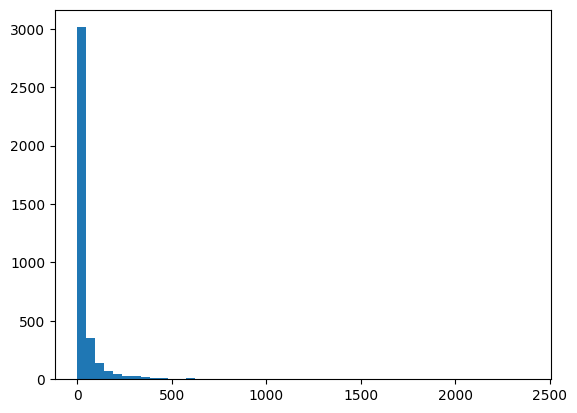

In [12]:
import matplotlib.pyplot as plt

train = split['train']['translation']
input_lens = [len(tr['en']) for tr in train]

plt.hist(input_lens, bins=50);

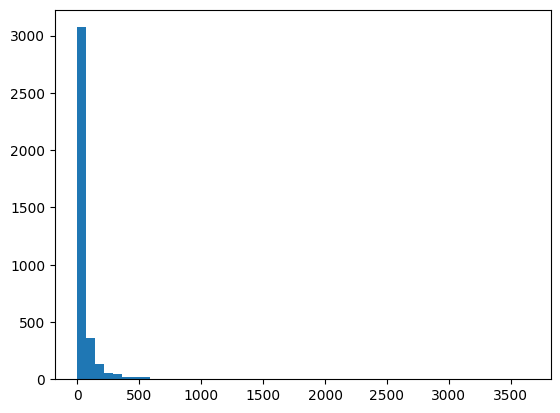

In [13]:
target_lens = [len(tr['fr']) for tr in train]
plt.hist(target_lens, bins=50);

In [14]:
max_input_len = 128
max_target_len = 128

def tokenizer_fn(batch):
    inputs = [x['en'] for x in batch['translation']]
    targets = [x['fr'] for x in batch['translation']]

    tokenized_inputs = tokenizer(
    inputs, max_length=max_input_len, truncation=True)

    tokenized_targets = tokenizer(
    text_target=targets, max_length=max_target_len, truncation=True)
    
    # map encoder labels to decorder input_ids
    tokenized_inputs['labels'] = tokenized_targets['input_ids']
    return tokenized_inputs

In [15]:
tokenized_datasets = split.map(
    tokenizer_fn,
    batched=True,
    remove_columns=split['train'].column_names,
)

Map:   0%|          | 0/3750 [00:00<?, ? examples/s]

Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

### Model and data collator

In [16]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [17]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

2024-06-10 07:16:19.681860: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 07:16:19.681951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 07:16:19.821013: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
tokenized_datasets["train"][0:2]

{'input_ids': [[32757, 529, 29450, 37, 301, 7889, 7, 301, 331, 3615, 334, 0],
  [402, 19335, 0]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1]],
 'labels': [[12433,
   5,
   8,
   6844,
   20,
   6,
   4698,
   402,
   38492,
   301,
   548,
   402,
   29033,
   3878,
   36,
   301,
   331,
   402,
   29033,
   156,
   985,
   2986,
   494,
   143,
   4896,
   4,
   338,
   197,
   114,
   170,
   75,
   874,
   10003,
   62,
   4642,
   529,
   0],
  [402, 28155, 0]]}

In [19]:
[tokenized_datasets["train"][i] for i in range(0, 2)]

[{'input_ids': [32757, 529, 29450, 37, 301, 7889, 7, 301, 331, 3615, 334, 0],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'labels': [12433,
   5,
   8,
   6844,
   20,
   6,
   4698,
   402,
   38492,
   301,
   548,
   402,
   29033,
   3878,
   36,
   301,
   331,
   402,
   29033,
   156,
   985,
   2986,
   494,
   143,
   4896,
   4,
   338,
   197,
   114,
   170,
   75,
   874,
   10003,
   62,
   4642,
   529,
   0]},
 {'input_ids': [402, 19335, 0],
  'attention_mask': [1, 1, 1],
  'labels': [402, 28155, 0]}]

In [20]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(0, 2)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [21]:
batch["labels"]

tensor([[12433,     5,     8,  6844,    20,     6,  4698,   402, 38492,   301,
           548,   402, 29033,  3878,    36,   301,   331,   402, 29033,   156,
           985,  2986,   494,   143,  4896,     4,   338,   197,   114,   170,
            75,   874, 10003,    62,  4642,   529,     0],
        [  402, 28155,     0,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100]])

In [22]:
# think of seq2seq RNNs - the decoder RNN must have "some" input
# it's just like a language model where we predict the next word from
# previous words!
batch["decoder_input_ids"]

tensor([[59513, 12433,     5,     8,  6844,    20,     6,  4698,   402, 38492,
           301,   548,   402, 29033,  3878,    36,   301,   331,   402, 29033,
           156,   985,  2986,   494,   143,  4896,     4,   338,   197,   114,
           170,    75,   874, 10003,    62,  4642,   529],
        [59513,   402, 28155,     0, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513]])

In [23]:
# the first token is a pad!
tokenizer.convert_ids_to_tokens(batch["decoder_input_ids"][0])

['<pad>',
 '▁Utilisation',
 '▁de',
 '▁la',
 '▁mémoire',
 '▁d',
 "'",
 'échange',
 '▁&',
 '▁#160;:',
 '▁%',
 '1',
 '▁&',
 '▁#160;',
 '%',
 '▁sur',
 '▁%',
 '2',
 '▁&',
 '▁#160;',
 '▁M',
 'ion',
 'ot',
 '▁available',
 '▁me',
 'ans',
 '▁the',
 '▁system',
 '▁do',
 'es',
 '▁no',
 't',
 '▁h',
 'ave',
 '▁s',
 'wa',
 'p']

In [24]:
# the labels are one step ahead - just like a language model
tokenizer.convert_ids_to_tokens(batch["labels"][0])

['▁Utilisation',
 '▁de',
 '▁la',
 '▁mémoire',
 '▁d',
 "'",
 'échange',
 '▁&',
 '▁#160;:',
 '▁%',
 '1',
 '▁&',
 '▁#160;',
 '%',
 '▁sur',
 '▁%',
 '2',
 '▁&',
 '▁#160;',
 '▁M',
 'ion',
 'ot',
 '▁available',
 '▁me',
 'ans',
 '▁the',
 '▁system',
 '▁do',
 'es',
 '▁no',
 't',
 '▁h',
 'ave',
 '▁s',
 'wa',
 'p',
 '</s>']

In [25]:
split['train'][1]

{'id': '166922', 'translation': {'en': '& Edit', 'fr': '& Édition'}}

### Metric

In [26]:
!pip install sacrebleu bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.1 MB/s eta 0:00:00


In [27]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")
bert_metric = load_metric("bertscore")

/tmp/ipykernel_34/3816762898.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for bertscore contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/bertscore/bertscore.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [28]:
s = "Marian is an efficient NMT framework written in pure C++"
bleu_metric.compute(predictions=[s], references=[[s]])

{'score': 100.00000000000004,
 'counts': [12, 11, 10, 9],
 'totals': [12, 11, 10, 9],
 'precisions': [100.0, 100.0, 100.0, 100.0],
 'bp': 1.0,
 'sys_len': 12,
 'ref_len': 12}

In [32]:
bert_metric.compute(
    predictions=["I love cats"], references=[["I like cats"]], lang='en')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.9803367853164673],
 'recall': [0.9803367853164673],
 'f1': [0.9803367853164673],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.39.3)'}

In [33]:
import numpy as np

def compute_metrics(preds_and_labels):
  # preds are not logits, but token ids
    preds, labels = preds_and_labels

    # convert predictions into words
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # for any -100 label, replace with pad token id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # convert labels into words
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # get rid of extraneous whitespace
    # and also, put targets into lists
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    bleu = bleu_metric.compute(
        predictions=decoded_preds, references=decoded_labels)
    bert_score = bert_metric.compute(
        predictions=decoded_preds, references=decoded_labels, lang='fr')

    return {"bleu": bleu["score"], 'bert_score': np.mean(bert_score['f1'])}

### Training Arguments

In [34]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
  "training_dir",
  evaluation_strategy="epoch",
  save_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=64,
  weight_decay=0.01,
  save_total_limit=3,
  num_train_epochs=5,
  predict_with_generate=True,
  fp16=True,report_to = "none"
)

### Trainer and performance metrics 

In [35]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### Training

In [36]:
trainer.train()  # takes around 14gb gpu, evaluation is v slow

Epoch,Training Loss,Validation Loss,Bleu,Bert Score
1,No log,1.358893,44.057691,0.877955
2,No log,1.305165,45.353101,0.878622
3,No log,1.281787,45.654444,0.878954
4,No log,1.272195,45.988149,0.879903
5,1.254400,1.270127,45.936014,0.880130


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strate

TrainOutput(global_step=590, training_loss=1.2187228315967624, metrics={'train_runtime': 814.5803, 'train_samples_per_second': 23.018, 'train_steps_per_second': 0.724, 'total_flos': 372674386722816.0, 'train_loss': 1.2187228315967624, 'epoch': 5.0})

### Inference

In [38]:
! ls /kaggle/working/training_dir

checkpoint-354	checkpoint-472	checkpoint-590


In [39]:
from transformers import pipeline

savedmodel = pipeline('translation',
                      model='training_dir/checkpoint-590',
                      device='cuda')


/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [42]:
savedmodel("I hope you found this notebook useful")


[{'translation_text': "J'espère que vous avez trouvé ce carnet utile"}]